In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.signal as signal
import pandas as pd
import visuals as vs
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import warnings
import sys, os

warnings.filterwarnings('ignore')
random_state = 6
np.random.seed(random_state)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
dir_path = '../../pipeline_modules/'
sys.path.append(dir_path)

In [3]:
# filename = 'seismogram_data_raw.csv'
filename = 'seismogram_data_cents_db.csv'
# filename = 'seismogram_data_cents_db_mfcc_delta.csv'
df = pd.read_csv(filename)
viz = vs.vizualization(df)

## Basic statistics

In [4]:
df.describe()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211
count,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,...,1606.000000,1606.000000,1606.000000,1606.0,1606.000000,1606.000000,1.606000e+03,1.606000e+03,1606.000000,1606.000000
mean,451.221669,941.665095,75.003741,9.231527,50.089629,9.011473,33.163889,11.137501,21.313839,13.738046,...,-79.980776,-79.979309,-79.978603,0.0,278.243072,-0.188070,3.743952e+12,5.021586e+17,31.972242,0.323163
std,302.649662,225.061154,37.099307,35.261332,19.673425,23.210687,12.591131,14.331587,7.673028,8.545568,...,0.190952,0.217414,0.185078,0.0,7662.201633,4.893058,2.781032e+13,4.202786e+18,763.247083,0.467830
min,0.000000,487.638894,0.590916,-95.650386,9.991572,-63.162621,5.273298,-38.585637,0.495500,-20.883890,...,-80.000008,-80.000008,-80.000008,0.0,-18424.601562,-148.536407,1.145826e+00,1.647420e+08,-1.557898,0.000000
25%,200.250000,775.150225,46.703585,-14.839313,36.362204,-7.899532,24.523875,2.047651,16.663696,9.773171,...,-80.000000,-80.000000,-80.000000,0.0,-0.564912,-0.066578,1.089125e+05,4.726152e+10,-0.056514,0.000000
50%,401.000000,900.926968,74.069958,12.228716,49.900223,12.684427,31.645115,14.229327,20.592639,15.489321,...,-80.000000,-80.000000,-80.000000,0.0,0.114271,-0.004160,1.769261e+06,7.682032e+11,0.241702,0.000000
75%,684.750000,1095.790912,100.281783,35.329806,63.719153,28.028384,40.849423,22.416433,25.514643,19.247300,...,-80.000000,-80.000000,-80.000000,0.0,2.218386,0.057529,6.593582e+08,8.217131e+14,1.950677,1.000000
max,1086.000000,1572.073401,202.898203,98.485401,123.096246,64.457973,81.809122,47.306912,52.774850,39.409499,...,-73.452782,-72.382477,-74.135483,0.0,300014.312500,11.173301,3.098055e+14,6.909585e+19,27426.243439,1.000000


In [6]:
# viz.check_datatype()

# Data Quality checks

### Visualize missing data

In [4]:
if (viz.check_null()):
    viz.check_missing_value(start=50, end=100)
else:
    print('Looks like there is no any missing value')

False
Looks like there is no any missing value


### Check class balance 

[ 0.  1.] [1087  519]


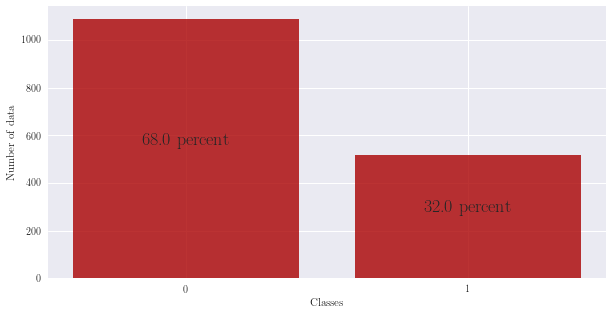

In [5]:
viz.check_data_balance(target_column = -1)

### Show correlation among the features

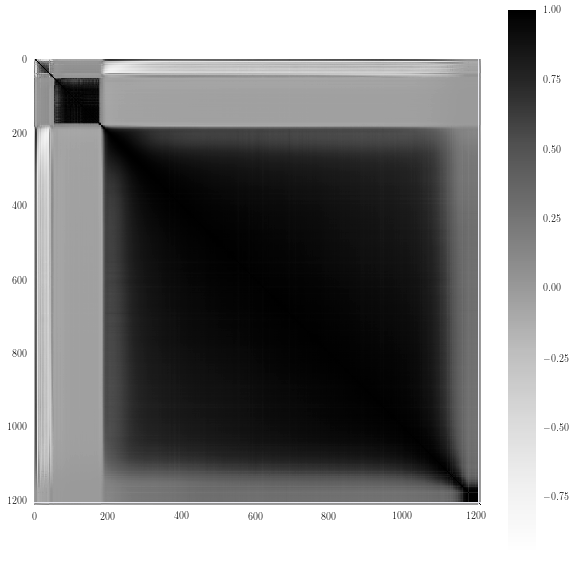

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(df.corr())
plt.colorbar()
plt.grid('off')
plt.show()

### Calculate PCA and see if the data are distinguishable

In [14]:
X = df.iloc[:,:df.shape[1]-1]
Y = df.iloc[:,-1]

X, Y = shuffle(X, Y, random_state = random_state)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=random_state)
mms = StandardScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

In [19]:
%reload_ext autoreload
%autoreload 2
import gridsearch as gs
mgs = gs.GridSearch(X_train, Y_train)

## Grid search for four algorithoms :
1. Random Forest classifier
2. Xgboot
3. LightGBM
4. Support vector machine

In [20]:
# perfomr grid search for the above algorithoms
mgs.create_gridclfs()

Algorithom_name: Support vector machine

Best paramiters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Best score: 0.9069767441860465

Best model: SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=10, shrinking=True,
  tol=0.001, verbose=False)

---------------------------- end ------------------------------- 



## Random forest classifier

In [64]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
rfc = RandomForestClassifier(criterion='entropy', random_state = random_state, class_weight='balanced')
params = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [10, 20, 40, 50]
}

grid_clf = GridSearchCV(estimator = rfc, param_grid = params, scoring = 'accuracy', cv = cv)

In [65]:
# we have to find out best optimized parameters
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100], 'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [10, 20, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [69]:
class_weight = {0:1, 1:2}
model = RandomForestClassifier(bootstrap=True, class_weight=class_weight,
            criterion='entropy', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=random_state, verbose=0, warm_start=False)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print('The accuracy of the model is {}'.format(accuracy_score(Y_test, Y_pred)))
print('Classification report \n {}'.format(classification_report(Y_test, Y_pred)))
print('Confusion matrix \n {}'.format(confusion_matrix(Y_pred, Y_test)))

The accuracy of the model is 0.8059701492537313
Classification report 
              precision    recall  f1-score   support

        0.0       0.88      0.83      0.85       276
        1.0       0.67      0.76      0.71       126

avg / total       0.82      0.81      0.81       402

Confusion matrix 
 [[228  30]
 [ 48  96]]


# Support Vector machine 

In [30]:
from sklearn import svm

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = random_state)
svm_clss = svm.SVC(class_weight = class_weight, random_state = random_state) 

svm_params = {
    'C': [1, 10, 100, 1000, 5000, 10000, 100000], 
    'gamma': [0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    'kernel': ['rbf', 'poly'],
    
}

grid_clf = GridSearchCV(estimator = svm_clss, param_grid = svm_params, scoring = 'accuracy', cv = cv)

In [31]:
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000, 5000, 10000, 100000], 'gamma': [0.01, 0.001, 0.0001, 1e-05, 1e-06], 'kernel': ['rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [32]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)
print(grid_clf.best_estimator_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.908637873754
SVC(C=1000, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)


In [75]:
model = svm.SVC(C=1000, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=random_state, shrinking=True,
  tol=0.001, verbose=False)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.9154228855721394

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.94      0.94      0.94       276
        1.0       0.87      0.87      0.87       126

avg / total       0.92      0.92      0.92       402
 

3. Confusion matrix 
 [[259  17]
 [ 17 109]] 

4. Roc_Auc score 
 0.9017425810904072
